# 中文连续词袋模型 (CBOW) 实现

## 1. 导入必要的库

In [34]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
import jieba  # 用于中文分词

## 2. 准备中文数据

In [35]:
sentence = "自然语言处理是人工智能的一个重要分支。它涉及计算机对人类语言的理解和生成。"

# 1. 中文分词
seg_list = jieba.cut(sentence, cut_all=False)  # 使用精确模式分词
segmented_sentence = " ".join(seg_list)

print(f"分词结果: {segmented_sentence}")

# 2. 数据预处理
tokenizer = Tokenizer()
tokenizer.fit_on_texts([segmented_sentence])

word_index = tokenizer.word_index
vocabulary_size = len(word_index) + 1  # +1 for the padding token (if needed)

print(f"词汇表大小: {vocabulary_size}")
print(f"单词索引: {word_index}")

encoded_sentence = tokenizer.texts_to_sequences([segmented_sentence])[0]

分词结果: 自然语言 处理 是 人工智能 的 一个 重要 分支 。 它 涉及 计算机 对 人类 语言 的 理解 和 生成 。
词汇表大小: 19
单词索引: {'的': 1, '。': 2, '自然语言': 3, '处理': 4, '是': 5, '人工智能': 6, '一个': 7, '重要': 8, '分支': 9, '它': 10, '涉及': 11, '计算机': 12, '对': 13, '人类': 14, '语言': 15, '理解': 16, '和': 17, '生成': 18}


## 3. 创建训练数据 (CBOW 上下文-目标词对)

In [36]:
def generate_cbow_pairs(corpus, window_size):
    context_length = 2 * window_size
    cbow_pairs = []
    for i in range(window_size, len(corpus) - window_size):
        context_words = [corpus[i - j] for j in range(window_size, 0, -1)]  # 前面的上下文词
        context_words += [corpus[i + j] for j in range(1, window_size + 1)]  # 后面的上下文词
        target_word = corpus[i]
        cbow_pairs.append((context_words, target_word))
    return cbow_pairs

window_size = 2
cbow_pairs = generate_cbow_pairs(encoded_sentence, window_size)

# 分离上下文词和目标词
context_words, target_words = zip(*cbow_pairs)

# 转换为 NumPy 数组
context_words = np.array(context_words)
target_words = np.array(target_words)

print(f"生成的 CBOW 词对数量: {len(cbow_pairs)}")
print(f"第一个词对: context={context_words[0]}, target={target_words[0]}")

生成的 CBOW 词对数量: 16
第一个词对: context=[3 4 6 1], target=5


# 4. 构建 CBOW 模型

In [37]:
# 4. 构建 CBOW 模型
embedding_dim = 50  # 词嵌入维度
context_length = 2 * window_size # 上下文长度

cbow_input = keras.Input(shape=(context_length,), dtype='int32') # 输入是上下文词序列
embedding = layers.Embedding(vocabulary_size, embedding_dim)(cbow_input)
average = layers.GlobalAveragePooling1D()(embedding) # 对词嵌入求平均
output = layers.Dense(vocabulary_size, activation='softmax')(average) # 使用 softmax 进行多分类

cbow = keras.Model(inputs=cbow_input, outputs=output)

cbow.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_13 (Embedding)        │ (None, 4, 50)          │           950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_10     │ (None, 50)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 19)             │           969 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,919 (7.50 KB)

 Trainable params: 1,919 (7.50 KB)

 Non-trainable params: 0 (0.00 B)

## 5. 编译和训练模型

In [38]:
# 5. 编译模型
cbow.compile(optimizer='adam',  # Adam 优化器
              loss='categorical_crossentropy',  # 适用于多分类问题
              metrics=['accuracy'])

# 将目标词转换为 one-hot 编码
target_words_one_hot = tf.keras.utils.to_categorical(target_words, num_classes=vocabulary_size)

print(f"context_words shape: {context_words.shape}")
print(f"target_words_one_hot shape: {target_words_one_hot.shape}")

context_words shape: (16, 4)
target_words_one_hot shape: (16, 19)


## 6. 训练模型

In [39]:
# 6. 训练模型
epochs = 100

cbow.fit(context_words, target_words_one_hot, epochs=epochs, batch_size=256, verbose=1)  # 开启 verbose，查看训练过程

print("训练完成!")

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0000e+00 - loss: 2.9455
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.0000e+00 - loss: 2.9412
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.0625 - loss: 2.9369
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.0625 - loss: 2.9326
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.1250 - loss: 2.9284
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.2500 - loss: 2.9241
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.3125 - loss: 2.9198
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4375 - loss: 2.9155
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.5000 - loss: 2.9112
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.5625 - loss: 2.9069
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.5625 - loss: 2.9026
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.6

## 7. 获取词嵌入

In [40]:
# 7. 获取词嵌入
embedding_layer = cbow.layers[1]  # Embedding 层现在是第二层
embeddings = embedding_layer.get_weights()[0]

print(f"词嵌入矩阵的形状: {embeddings.shape}")  # (vocabulary_size, embedding_dim)

# 获取 "计算机" 的词嵌入
word = "计算机"
word_id = word_index[word]
embedding_vector = embeddings[word_id]

print(f"'{word}' 的词嵌入: {embedding_vector}")


词嵌入矩阵的形状: (19, 50)
'计算机' 的词嵌入: [-0.12553069  0.10213146  0.09594     0.15062957  0.14791958 -0.0935752
  0.21165147 -0.00703841  0.21184948 -0.16255817 -0.07577461  0.23779415
 -0.21095549  0.03916166 -0.06039023 -0.12436868 -0.17965183 -0.00406685
  0.00344226  0.12719455 -0.15322256  0.03567335  0.00178656 -0.1429299
  0.03928113  0.17985073  0.12053124 -0.20956117 -0.02914449  0.1490389
  0.04167986 -0.0372927  -0.12301474  0.11296449  0.14533854  0.13683203
  0.01195415 -0.14889722  0.0084296  -0.15990458  0.11018334  0.04844944
  0.03575176  0.00351978 -0.08600586 -0.12438011  0.1431647   0.20687006
 -0.04966841  0.01969392]


生成训练样本数: 39
词汇表: ['向', '要', '模', '可', '理', '文', '效', '训', '取', '据', '征', '影', '自', '人', '深', '大', '处', '量', '算', '语', '言', '以', '相', '需', '词', '数', '解', '上', '义', '似', '计', '口', '下', '响', '提', '度', '让', '类', '机', '型', '习', '果', '性', '窗', '然', '捕', '练', '捉', '学', '特']

开始训练...
Epoch   10 | Loss: 3.9206 | Acc: 2.56% | LR: 0.10000
Epoch   20 | Loss: 3.9093 | Acc: 5.13% | LR: 0.10000
Epoch   30 | Loss: 3.8974 | Acc: 5.13% | LR: 0.10000
Epoch   40 | Loss: 3.8855 | Acc: 5.13% | LR: 0.10000
Epoch   50 | Loss: 3.8735 | Acc: 7.69% | LR: 0.10000
Epoch   60 | Loss: 3.8617 | Acc: 15.38% | LR: 0.09500
Epoch   70 | Loss: 3.8496 | Acc: 17.95% | LR: 0.09500
Epoch   80 | Loss: 3.8373 | Acc: 20.51% | LR: 0.09500
Epoch   90 | Loss: 3.8245 | Acc: 20.51% | LR: 0.09500
Epoch  100 | Loss: 3.8116 | Acc: 23.08% | LR: 0.09500
Epoch  110 | Loss: 3.7989 | Acc: 30.77% | LR: 0.09025
Epoch  120 | Loss: 3.7854 | Acc: 30.77% | LR: 0.09025
Epoch  130 | Loss: 3.7714 | Acc: 30.77% | LR: 0.09025
Epoch  140 | Loss: 3.7569 

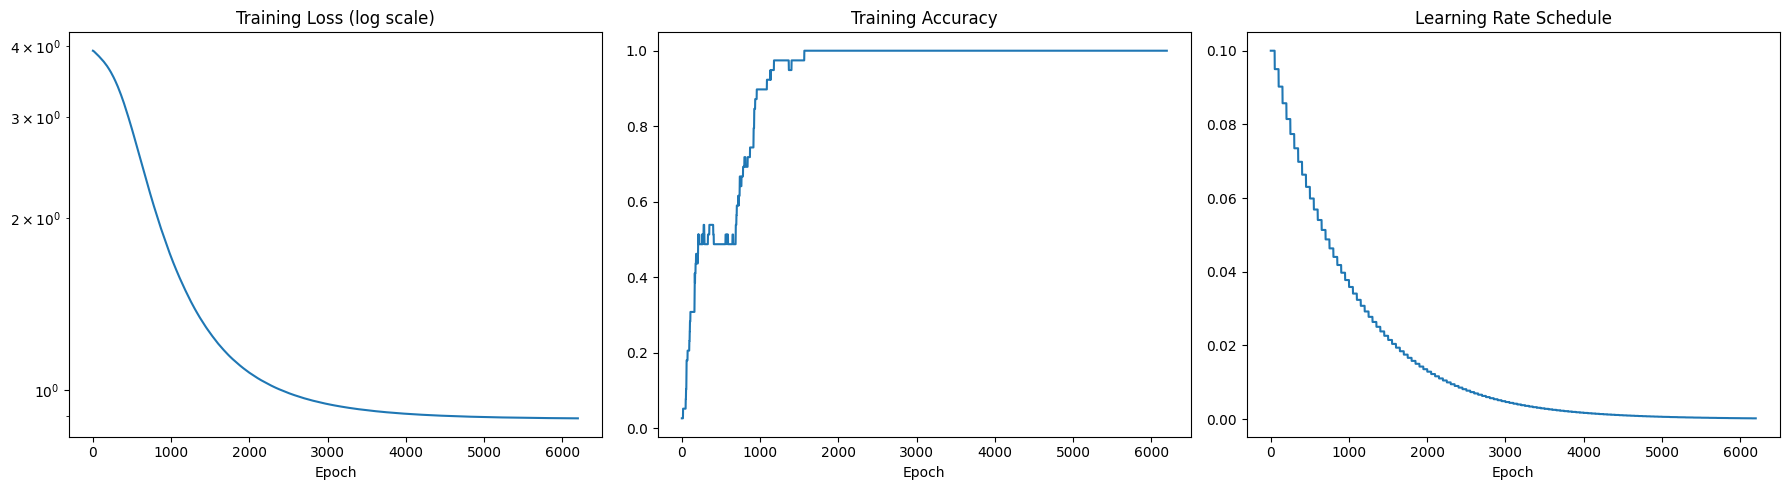

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21521 (\N{CJK UNIFIED IDEOGRAPH-5411}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 35201 (\N{CJK UNIFIED IDEOGRAPH-8981}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21487 (\N{CJK UNIFIED IDEOGRAPH-53EF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29702 (\N{CJK UNIFIED IDEOGRAPH-7406}) missing from font(s) DejaVu Sans.
  fig.canvas

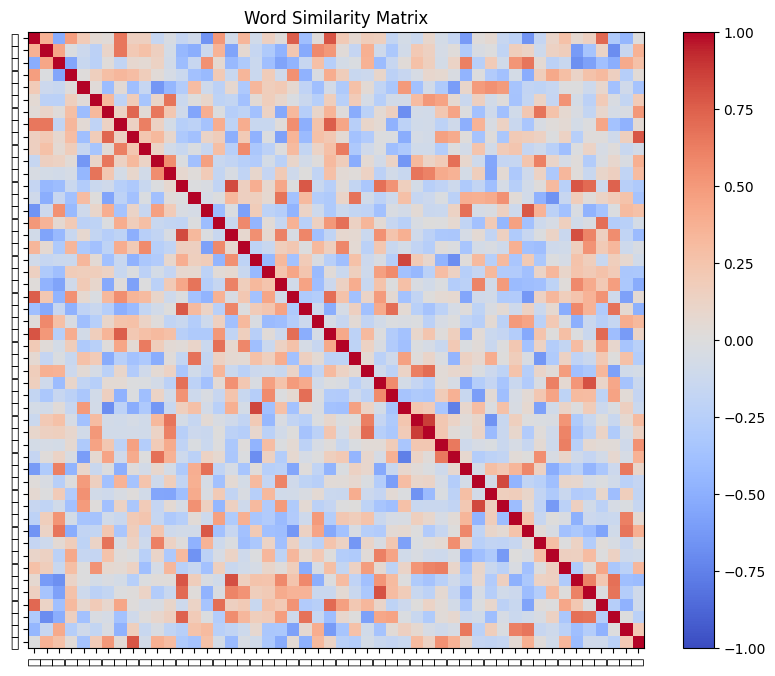


示例词向量：
向: [ 0.0503 -0.0248  0.3238  1.4903 -0.6487  0.0779  0.2781 -0.1635  0.0015
 -0.1505 -0.6956 -0.561   0.1128  0.3304 -0.7921  0.1755]
要: [-0.6795 -0.0673 -0.2285  0.1768  0.7021 -0.7057  0.1153 -0.1233  1.0552
 -1.1208 -0.6617 -0.7392 -0.4702  0.6045 -1.6025  0.7403]
模: [-0.3816  0.3627 -0.2535 -1.5033  1.5003 -0.7334 -1.1623 -0.4973  0.5289
 -0.5042 -0.3376  0.4126 -0.5915 -0.0364 -0.5843 -0.0489]
可: [ 4.670e-01 -8.823e-01 -2.923e-01  7.027e-01 -5.675e-01  6.895e-01
  3.796e-01  7.829e-01 -6.165e-01 -2.490e-01 -1.577e-01  2.350e-01
 -8.000e-04  6.344e-01 -6.024e-01 -4.670e-02]
理: [ 0.9239  1.0258  0.3408  0.2977 -0.8415 -1.5523  1.37    0.2317  0.1073
  0.1515 -1.8774  1.2459  0.2951 -0.0051  0.3229 -1.074 ]
文: [-0.1383  0.1874  0.6286 -0.0171 -0.7337 -0.2157  0.2248  0.5197 -0.8042
  0.5432  0.6532  0.2881 -0.685  -0.6663 -0.7667  0.1087]
效: [ 0.0577  0.1107  0.3926 -0.2634 -0.3113  0.3363 -0.2084 -0.165  -0.7388
 -0.5528  0.7874  0.0472 -0.6102  0.9419 -0.4359  0.5475]
训: [-

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from typing import Dict, List, Tuple

np.random.seed(42)

# ======================
# 测试数据优化
# ======================
sentences = [
    "自然语言处理让计算机理解人类语言",
    "深度学习模型需要大量训练数据",
    "词向量可以捕捉语义相似性",
    "上下文窗口影响特征提取效果"
]

# ======================
# 超参数配置
# ======================
CONFIG = {
    "window_size": 2,
    "embedding_dim": 16,
    "initial_lr": 0.1,
    "min_epochs": 200,
    "patience": 50,
    "min_delta": 1e-4,
    "l2_lambda": 0.001,
    "momentum": 0.9,
    "max_grad_norm": 5.0,
    "batch_size": 32
}


# ======================
# 数据预处理
# ======================
def build_vocab(sentences: List[str]) -> Tuple[List[str], Dict, Dict]:
    words = [word for sent in sentences for word in list(sent)]
    vocab = list(set(words))
    return vocab, \
           {word: idx for idx, word in enumerate(vocab)}, \
           {idx: word for idx, word in enumerate(vocab)}


def create_cbow_data(sentences: List[str], window_size: int) -> List[Tuple]:
    data = []
    for sent in sentences:
        words = list(sent)
        for i in range(window_size, len(words) - window_size):
            context = [words[i + j] for j in range(-window_size, window_size + 1) if j != 0]
            target = words[i]
            data.append((context, target))
    return data


# ======================
# CBOW 模型类
# ======================
class CBOW_Model:
    def __init__(self, vocab_size: int, config: dict):
        self.vocab_size = vocab_size
        self.config = config

        self.embed_weights = np.random.randn(vocab_size, config["embedding_dim"]) * np.sqrt(2. / (vocab_size + config["embedding_dim"]))
        self.context_weights = np.random.randn(config["embedding_dim"], vocab_size) * np.sqrt(2. / (config["embedding_dim"] + vocab_size))

        self.embed_momentum = np.zeros_like(self.embed_weights)
        self.context_momentum = np.zeros_like(self.context_weights)

    def softmax(self, x: np.ndarray) -> np.ndarray:
        x = x - np.max(x)
        e_x = np.exp(x)
        return e_x / np.sum(e_x)

    def forward_backward(self, context_indices: List[int], target_idx: int) -> Tuple[float, np.ndarray, np.ndarray, np.ndarray]:
        x = np.zeros(self.vocab_size)
        for idx in context_indices:
            x[idx] += 1 / len(context_indices)

        h = np.dot(x, self.embed_weights)
        logits = np.dot(h, self.context_weights)
        probs = self.softmax(logits)

        loss = -np.log(probs[target_idx] + 1e-8) + 0.5 * self.config["l2_lambda"] * (
            np.sum(self.embed_weights ** 2) + np.sum(self.context_weights ** 2))

        d_logits = probs.copy()
        d_logits[target_idx] -= 1

        grad_context = np.outer(h, d_logits) + self.config["l2_lambda"] * self.context_weights
        dh = np.dot(self.context_weights, d_logits)
        grad_embed = np.outer(x, dh) + self.config["l2_lambda"] * self.embed_weights

        return loss, grad_embed, grad_context, probs

    def update_parameters(self, gradients: Tuple[np.ndarray, np.ndarray], lr: float):
        grad_embed, grad_context = gradients

        total_norm = np.sqrt(np.sum(grad_embed ** 2) + np.sum(grad_context ** 2))
        if total_norm > self.config["max_grad_norm"]:
            scale = self.config["max_grad_norm"] / total_norm
            grad_embed *= scale
            grad_context *= scale

        self.embed_momentum = self.config["momentum"] * self.embed_momentum + (1 - self.config["momentum"]) * grad_embed
        self.context_momentum = self.config["momentum"] * self.context_momentum + (1 - self.config["momentum"]) * grad_context

        self.embed_weights -= lr * self.embed_momentum
        self.context_weights -= lr * self.context_momentum


# ======================
# 模型训练
# ======================
def train_model(sentences: List[str], config: dict) -> Tuple[CBOW_Model, dict, Dict, Dict]:
    vocab, word_to_idx, idx_to_word = build_vocab(sentences)
    training_data = create_cbow_data(sentences, config["window_size"])
    print(f"生成训练样本数: {len(training_data)}")
    print(f"词汇表: {vocab}")

    model = CBOW_Model(len(vocab), config)
    history = defaultdict(list)
    best_loss = float('inf')
    no_improve = 0

    print("\n开始训练...")
    for epoch in range(10000):
        lr = config["initial_lr"] * (0.95 ** (epoch // 50))
        total_loss = 0
        correct = 0

        np.random.shuffle(training_data)

        for i in range(0, len(training_data), config["batch_size"]):
            batch = training_data[i:i + config["batch_size"]]
            if len(batch) == 0:
                continue

            batch_grad_e = np.zeros_like(model.embed_weights)
            batch_grad_c = np.zeros_like(model.context_weights)

            for context, target in batch:
                context_idx = [word_to_idx[w] for w in context]
                target_idx = word_to_idx[target]

                loss, grad_e, grad_c, probs = model.forward_backward(context_idx, target_idx)
                predicted_idx = np.argmax(probs)
                if predicted_idx == target_idx:
                    correct += 1

                batch_grad_e += grad_e
                batch_grad_c += grad_c
                total_loss += loss

            batch_grad_e /= len(batch)
            batch_grad_c /= len(batch)
            model.update_parameters((batch_grad_e, batch_grad_c), lr)

        avg_loss = total_loss / len(training_data)
        accuracy = correct / len(training_data)
        history['loss'].append(avg_loss)
        history['acc'].append(accuracy)
        history['lr'].append(lr)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1:4d} | Loss: {avg_loss:.4f} | Acc: {accuracy:.2%} | LR: {lr:.5f}")

        if epoch >= config["min_epochs"]:
            if avg_loss < best_loss - config["min_delta"]:
                best_loss = avg_loss
                no_improve = 0
            else:
                no_improve += 1
            if no_improve >= config["patience"]:
                print(f"\n早停触发：连续 {config['patience']} 轮损失未改善")
                break

    print(f"训练结束，最优损失: {best_loss:.4f}")
    return model, history, word_to_idx, idx_to_word


# ======================
# 可视化
# ======================
def visualize_results(model: CBOW_Model, history: dict, idx_to_word: Dict[int, str]):
    plt.figure(figsize=(18, 5))
    plt.subplot(1, 3, 1)
    plt.semilogy(history['loss'])
    plt.title("Training Loss (log scale)")
    plt.xlabel("Epoch")

    plt.subplot(1, 3, 2)
    plt.plot(history['acc'])
    plt.title("Training Accuracy")
    plt.xlabel("Epoch")

    plt.subplot(1, 3, 3)
    plt.plot(history['lr'])
    plt.title("Learning Rate Schedule")
    plt.xlabel("Epoch")
    plt.tight_layout()

    # 相似度矩阵
    vectors = model.embed_weights
    sim_matrix = vectors @ vectors.T
    norms = np.linalg.norm(vectors, axis=1, keepdims=True)
    sim_matrix /= (norms @ norms.T)

    plt.figure(figsize=(10, 8))
    plt.imshow(sim_matrix, cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar()
    plt.xticks(range(len(idx_to_word)), [idx_to_word[i] for i in range(len(idx_to_word))], rotation=90)
    plt.yticks(range(len(idx_to_word)), [idx_to_word[i] for i in range(len(idx_to_word))])
    plt.title("Word Similarity Matrix")
    plt.show()


# ======================
# 主程序
# ======================
if __name__ == "__main__":
    trained_model, training_history, word_to_idx, idx_to_word = train_model(sentences, CONFIG)
    visualize_results(trained_model, training_history, idx_to_word)

    print("\n示例词向量：")
    for idx in range(len(idx_to_word)):
        word = idx_to_word[idx]
        print(f"{word}: {trained_model.embed_weights[idx].round(4)}")
